# Import dependencies

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt


# Connect to database

In [3]:
# Connect to sqlite database using SQLAlchemy ORM

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

from sqlalchemy.sql import operators, extract
from dateutil.relativedelta import relativedelta
from sqlalchemy import and_

In [4]:
# Create_engine to connect to your sqlite database.

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables

# Use the Inspector to explore the database and print the table names
# YOUR CODE HERE
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [6]:
# Use Inspector to print the column names and types
# YOUR CODE HERE
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Use Inspector to print the column names and types
# YOUR CODE HERE
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and 
# save a reference to those classes called Station and Measurement.
# View all of the classes that automap found
# Reflect Database into ORM class

Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement

In [9]:
# Save references to each table
# Reflect Database into ORM class

Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
# Start a session to query the database

session = Session(engine)

## Temperature Analysis II

In [11]:
# You are looking to take a trip from August first to August seventh of this year, 
# but are worried that the weather will be less than ideal.
# Using historical data in the dataset find out what the temperature has previously looked like.

# Create a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d.
# The function will return the minimum, average, and maximum temperatures for that range of dates.


start_date = '2017-08-01'
end_date = '2017-08-07'

def calc_temps(start_date, end_date):
   
    # you put the columns what you want to see in the output in this list 


    sel = [func.min(Measurement.tobs), 
           func.avg(Measurement.tobs),  
           func.max(Measurement.tobs)]
    
    # Now query from sel data columns 
    # .all() takes the result and puts into a list of tuples

    range_aggregates = session.query(*sel).\
              filter(and_(Measurement.date >= start_date), (Measurement.date <= end_date)).all()
    
    return (range_aggregates)           

# Calling function 'calc_temps'
range_aggregates = calc_temps(start_date, end_date)
range_aggregates

[(72.0, 79.25, 83.0)]

In [12]:
# Use the calc_temps function to calculate the min, avg, and max temperatures 
#for your trip using the matching dates from a previous year (i.e., use "2017-08-01").

start_date = '2017-08-01'
end_date = '2017-08-07'

#recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Converting str type date into datetime
lastyear_start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
lastyear_end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

# 12 month relativedelta
twelve_mon_rel = relativedelta(months=12)

# Query for the previous date--12 months from '2017-08-23'` using the datetime library
query_date1 = lastyear_start_date - twelve_mon_rel
query_date2 = lastyear_end_date - twelve_mon_rel

# Calling function 'calc_temps' for geting temperatures average for previous year
range_aggregates = calc_temps(query_date1, query_date2)
range_aggregates  


[(72.0, 78.05263157894737, 83.0)]

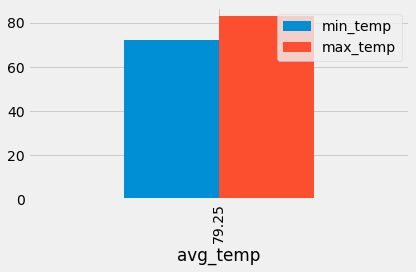

In [63]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use "Trip Avg Temp" as the title.
# Use the average temperature as the bar height (y value).
# Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).


# Get the results in to List comprehension 
df = pd.DataFrame(range_aggregates, columns=['min_temp', 'avg_temp', 'max_temp'])

# Plot the Results in a Matplotlib bar chart

df.set_index('avg_temp', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()
     


## Daily Rainfall Average

In [78]:
# Query rainfall per weather station for previous year, sorted by precipitation
# Include station, name, latitude, longitude, and elevation

sel = [Measurement.station, Measurement.prcp, Station.station, Station.name, Station.latitude, Station.elevation]

query_rainfall = session.query(*sel).filter(Measurement.station == Station.station).\
                 filter(and_(Measurement.date >= query_date1, Measurement.date >= query_date2)).\
                 order_by(Measurement.prcp.desc()).limit(2).all()
query_rainfall

# for record in query_rainfall:
#     (me_station, me_prcp, sa_name, sa_lat, sa_elev) = record
#     print(
#         f"The rainfall '{me_station} {me_prcp} {sa_name}'"
#         f"'{sa_lat} {sa_elev}'.")


[('USC00516128',
  6.7,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  152.4),
 ('USC00519523',
  6.25,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  19.5)]

In [82]:
# Convert list of tuples into normal list and retrieving 'station name'        
filtered_by_date = list(np.ravel(query_rainfall))
#filtered_by_date

## Daily Temperature Normals

In [84]:
# Use the calc_temps function to calculate the min, avg, and max temperatures 
#for your trip using the matching dates from a previous year (i.e., use "2017-08-01").

start_date = '2017-08-01'
end_date = '2017-08-07'

#recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Converting str type date into datetime
query_date1 = dt.datetime.strptime(start_date, '%Y-%m-%d')
query_date2 = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Calling function 'calc_temps' for geting temperatures average for previous year
range_aggregates = calc_temps(query_date1, query_date2)
range_aggregates  

[(72.0, 78.05263157894737, 83.0)]

In [95]:
# testing
# x = session.query(func.strftime('%m-%d',query_date1), func.strftime('%m-%d',query_date2)).all()
# x

[('08-01', '08-07')]

In [102]:
def daily_normals(query_date1, query_date2):
    
    
    sel = [func.min(Measurement.tobs), 
      func.avg(Measurement.tobs),  
       func.max(Measurement.tobs)]
             
    # Now query from sel data columns '
    # .all() takes the result and puts into a list of tuples

    range_aggregates = session.query(*sel).\
          filter(and_(func.strftime('%m-%d',Measurement.date) >= func.strftime('%m-%d',query_date1)),\
                 (func.strftime('%m-%d',Measurement.date) <= func.strftime('%m-%d',query_date2))).all() 
    
    return (range_aggregates)

range_aggregates = daily_normals(query_date1, query_date2)
range_aggregates

[(67.0, 76.28918918918919, 85.0)]

In [110]:
# Convert list of tuples into normal list        
filtered_by_date = list(np.ravel(range_aggregates))
filtered_by_date

[72.0, 79.25, 83.0]

In [40]:
# Calculate the daily normals for each day of your trip (inclusive)
start_date = '2017-08-01'
end_date = '2017-08-07'

sel = [func.min(Measurement.tobs), 
      func.avg(Measurement.tobs),  
       func.max(Measurement.tobs)]
             
    # Now query from sel data columns '
    # .all() takes the result and puts into a list of tuples

range_aggregates = session.query(*sel).\
          filter(and_(Measurement.date >= start_date),\
                 (Measurement.date <= end_date)).all() 
range_aggregates

[(72.0, 79.25, 83.0)]

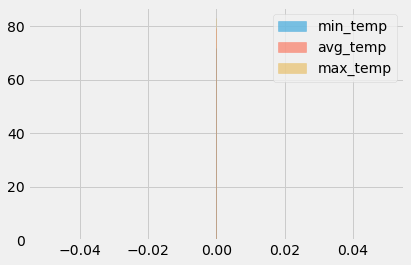

In [66]:
import pandas as pd
import matplotlib.pyplot as plot


# Plot the daily normals as an area plot with `stacked=False`

df = pd.DataFrame(range_aggregates, columns=['min_temp', 'avg_temp', 'max_temp'])


ax = df.plot.area(stacked=False)


## Close Session

In [107]:
session.close()